In [17]:
import numpy as np 
import pandas as pd 
import sqlite3

import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt 
plt.style.use ('ggplot') 
from matplotlib.pyplot import figure 

%matplotlib inline 
matplotlib.rcParams ['figure.figsize'] = (12,8) # adjust the configuration of the plots we will create 

#Connect to the SQLite database 
conn = sqlite3.connect('/Users/haiyen/Downloads/archive/database.sqlite') 




In [6]:
# Create a cursor object 
cursor = conn.cursor ()

#Execute a query to fetch table names 
cursor.execute("SELECT name FROM sqlite_master WHERE type ='table';") 
tables = cursor.fetchall()

# Display table names 
print ("Tables in the database:") 
for table in tables: 
    print (table[0]) 

Tables in the database:
matches
players
rankings


In [11]:
# Query data from the 'players' table and display it using pandas 
query = "SELECT * FROM players LIMIT 5;" # fetch first 5 rows from the 'player' table 
df = pd.read_sql_query (query, conn)

#Display the DatatFrame 
print ("\nFirst 5 rows from the 'player' table:") 
print (df) 


First 5 rows from the 'player' table:
   player_id name_first name_last hand         dob  ioc  height wikidata_id
0     100001    Gardnar    Mulloy    R  19131122.0  USA   185.0      Q54544
1     100002     Pancho    Segura    R  19210620.0  ECU   168.0      Q54581
2     100003      Frank   Sedgman    R  19271002.0  AUS   180.0     Q962049
3     100004   Giuseppe     Merlo    R  19271011.0  ITA     NaN    Q1258752
4     100005    Richard  Gonzalez    R  19280509.0  USA   188.0      Q53554


In [146]:
# select the ranking year and count the number of distinct players for each year 
cursor = conn.cursor()
cursor.execute (""" CREATE TEMP TABLE glue AS 
SELECT 
Substr(cast(ranking_date as string), 1, 4) as ranking_year
, count(distinct player) as number_of_players, sum(points) as maxPoints
, avg(points) as avgPoints 
FROM rankings 
GROUP BY ranking_year 
ORDER BY ranking_year;""")
conn.commit()
print ("\nYearly players amount:") 
print (glue) 


Yearly players amount:
   ranking_year  number_of_players   maxPoints   avgPoints
0          1973                241         NaN         NaN
1          1974                415         NaN         NaN
2          1975                503         NaN         NaN
3          1976                454         NaN         NaN
4          1977                404         NaN         NaN
5          1978                688         NaN         NaN
6          1979                814         NaN         NaN
7          1980                506         NaN         NaN
8          1981                146         NaN         NaN
9          1982                433         NaN         NaN
10         1983               1044         NaN         NaN
11         1984               1301         NaN         NaN
12         1985               1335         NaN         NaN
13         1986               1397         NaN         NaN
14         1987               1476         NaN         NaN
15         1988               15

In [50]:
print("Available columns:", glue.columns.tolist())

Available columns: ['ranking_year', 'number_of_players', 'maxPoints', 'avgPoints']


In [79]:
# Clean and prepare the dataset 
glue['ranking_year'] = glue['ranking_year'].astype(int)
df = glue.sort_values('ranking_year')
df = glue.set_index('ranking_year')
df = glue.dropna(subset=["maxPoints", "avgPoints"], how="any")
# Sort by ranking_year and filter out years from 1973 to 1989
df_filtered = df[~df['ranking_year'].between(1973, 1989)]
df_filtered = df_filtered.sort_values('ranking_year')

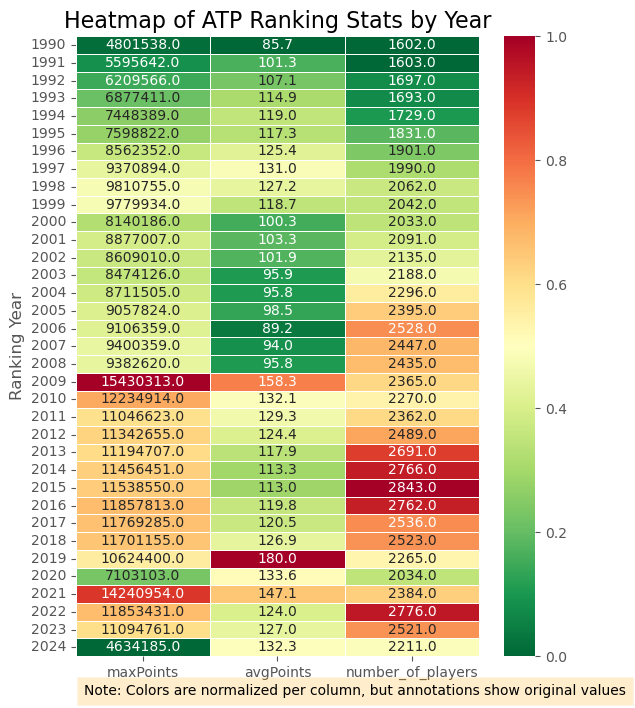

In [85]:
heatmap_data = df_filtered.groupby('ranking_year')[['maxPoints', 'avgPoints', 'number_of_players']].mean()

# Normalize each column separately
from sklearn.preprocessing import MinMaxScaler

# Create a copy to avoid modifying the original data
normalized_data = heatmap_data.copy()

# Apply normalization to each column independently
for column in normalized_data.columns:
    scaler = MinMaxScaler()
    normalized_data[column] = scaler.fit_transform(normalized_data[[column]])


# Create the heatmap
plt.figure(figsize=(6,7))
ax = sns.heatmap(normalized_data, cmap="RdYlGn_r", annot=heatmap_data.values, fmt=".1f", linewidths=0.5)

plt.title("Heatmap of ATP Ranking Stats by Year", fontsize=16)
plt.xlabel("")
plt.ylabel("Ranking Year")

# Adjust x-tick labels to be horizontal
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")

# Add a note about normalization
plt.figtext(0.6, 0, "Note: Colors are normalized per column, but annotations show original values", 
            ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
plt.tight_layout()
plt.show()

In [153]:
cursor = conn.cursor ()
cursor.execute(""" CREATE TEMP TABLE ranking_enriched AS 
SELECT *, Substr(cast(ranking_date as string), 1, 4) as ranking_year FROM rankings ;""")
conn.commit()
print (ranking_enriched)

         ranking_date  rank  player  points ranking_year
0            20000110     1  101736  4135.0         2000
1            20000110     2  102338  2915.0         2000
2            20000110     3  101948  2419.0         2000
3            20000110     4  103017  2184.0         2000
4            20000110     5  102856  2169.0         2000
...               ...   ...     ...     ...          ...
3235634      19771212    95  100586     NaN         1977
3235635      19771212    97  100363     NaN         1977
3235636      19771212    98  100176     NaN         1977
3235637      19771212    99  100233     NaN         1977
3235638      19771212    99  100359     NaN         1977

[3235639 rows x 5 columns]


In [138]:
cursor = conn.cursor()

cursor.execute("""
CREATE TEMP TABLE ranked_players AS
SELECT player
,count (*) as ranked_first
,count(distinct Substr(cast(ranking_date as string), 1, 4)) as years_first 
FROM rankings 
WHERE rank = 1 GROUP BY player ORDER BY ranked_first desc 
LIMIT 10
""")

conn.commit()

print ("\Top 10 players:")
print (ranked_players) 

\Top 10 players:
   player  ranked_first  years_first
0  104925           377           13
1  103819           307            9
2  101948           285            8
3  100656           228            8
4  104745           193           10
5  100581           136            6
6  100284           104            8
7  101736           100            5
8  100437            94            4
9  103720            80            3


In [142]:
query = """SELECT p.name_first||" "|| p.name_last as player_name
                , r.ranked_first 
                ,r.years_first
FROM ranked_players as r 
LEFT JOIN players as p
ON r.player = p.player_id; """
ranked_playerss = pd.read_sql_query (query,conn) 
print ("\Top 10 players:")
print (ranked_playerss) 

\Top 10 players:
      player_name  ranked_first  years_first
0  Novak Djokovic           377           13
1   Roger Federer           307            9
2    Pete Sampras           285            8
3      Ivan Lendl           228            8
4    Rafael Nadal           193           10
5    John McEnroe           136            6
6   Jimmy Connors           104            8
7    Andre Agassi           100            5
8      Bjorn Borg            94            4
9  Lleyton Hewitt            80            3


In [227]:
cursor = conn.cursor()

cursor.execute("""
CREATE TEMP TABLE zxc AS
SELECT  r.ranking_year
        ,r.points 
        ,r.rank, p.*, p.name_first||" "||p.name_last as player_name
FROM  ranking_enriched as r
LEFT JOIN players as p ON p.player_id = r.player
Group by r.points
order by r.points;
""")

conn.commit()

OperationalError: table zxc already exists

In [174]:
cursor = conn.cursor ()
cursor.execute ("""
CREATE TEMP TABLE ranked_age AS 
SELECT
    ranking_year,
    AVG(ranking_year - CAST(SUBSTR(dob, 1, 4) AS INT)) AS average_age
FROM
    zxc
WHERE rank = 1
GROUP BY
    ranking_year
order by ranking_year asc;""")
print(ranked_age) 

   ranking_year  average_age
0          1973    27.000000
1          1974    24.600000
2          1975    23.000000
3          1976    24.000000
4          1977    24.875000
5          1978    26.000000
6          1979    24.128205
7          1980    23.733333
8          1981    23.714286
9          1982    24.272727
10         1983    24.790698
11         1984    24.697674
12         1985    25.642857
13         1986    26.000000
14         1987    27.000000
15         1988    26.666667
16         1989    28.813953
17         1990    27.692308
18         1991    24.769231
19         1992    22.846154
20         1993    22.326923
21         1994    23.000000
22         1995    24.576923
23         1996    25.490566
24         1997    26.000000
25         1998    26.538462
26         1999    27.807692
27         2000    28.941176
28         2001    23.811321
29         2002    21.000000
30         2003    24.942308
31         2004    22.923077
32         2005    24.000000
33         200

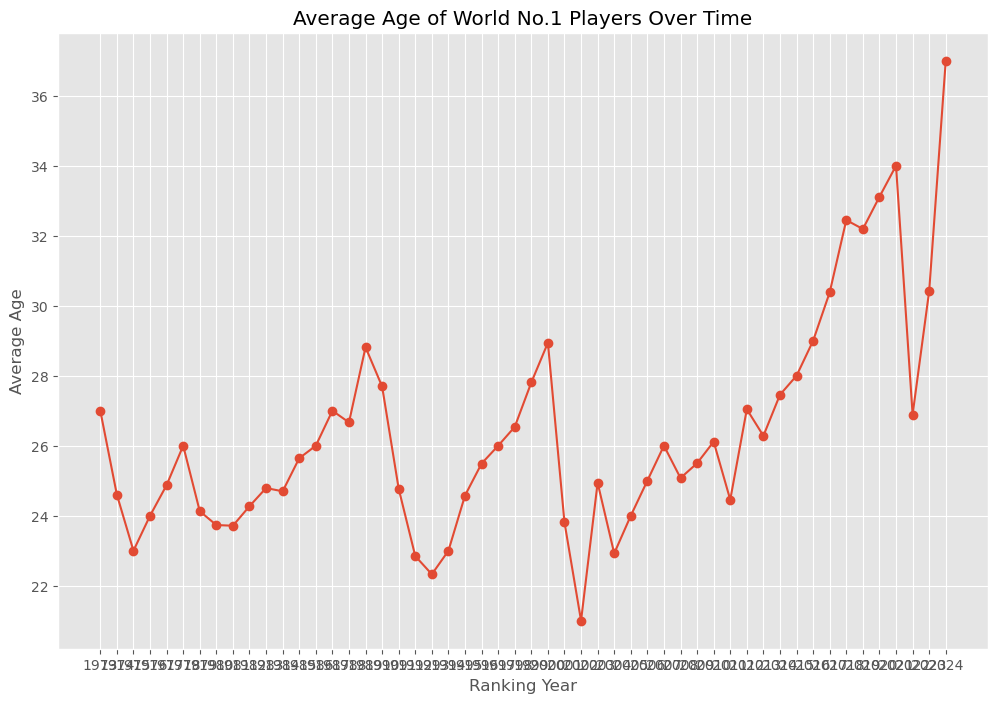

In [175]:
# visualise the dataset
df = ranked_age.copy()
df = df.dropna(subset = ["ranking_year", "average_age"])
df = df.sort_values(["ranking_year"])

plt.figure()
plt.plot(df["ranking_year"], df["average_age"], marker="o")
plt.xlabel("Ranking Year")
plt.ylabel("Average Age")
plt.title("Average Age of World No.1 Players Over Time")
plt.show()


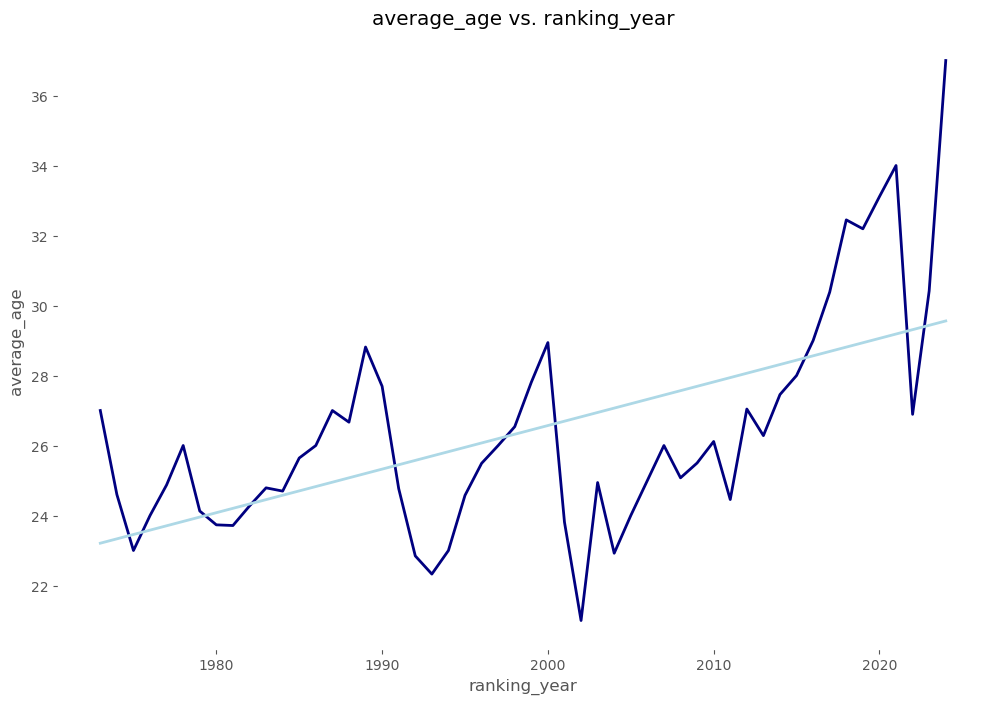

In [181]:

# X and Y
x = df["ranking_year"].astype(float)
y = df["average_age"].astype(float)

# Trend line (linear regression)
coef = np.polyfit(x, y, 1)
trend = np.poly1d(coef)

# Set the background to white 
plt.figure(facecolor = 'white')
plt.rcParams['axes.facecolor'] = 'white'
#Plot
plt.plot(x, y, linewidth=2, color = 'navy')
plt.plot(x, trend(x), linestyle="-", linewidth=2, color='lightblue')

plt.xlabel("ranking_year")
plt.ylabel("average_age")
plt.title("average_age vs. ranking_year")

plt.show()


In [187]:
cursor = conn.cursor()

cursor.execute("""
CREATE TEMP TABLE top_rank AS
SELECT
    ranking_year,
    MAX(CASE WHEN rank = 1 THEN average_age ELSE NULL END) AS rank_1,
    MAX(CASE WHEN rank = 2 THEN average_age ELSE NULL END) AS rank_2,
    MAX(CASE WHEN rank = 3 THEN average_age ELSE NULL END) AS rank_3,
    MAX(CASE WHEN rank = 4 THEN average_age ELSE NULL END) AS rank_4,
    MAX(CASE WHEN rank = 5 THEN average_age ELSE NULL END) AS rank_5,
    MAX(CASE WHEN rank < 10 THEN average_age ELSE NULL END) AS top_10,
    MAX(CASE WHEN rank < 100 THEN average_age ELSE NULL END) AS top_100,
    MAX(CASE WHEN rank >= 100 THEN average_age ELSE NULL END) AS others    
FROM (
    SELECT
        ranking_year,
        rank,
        AVG(ranking_year - CAST(SUBSTR(dob, 1, 4) AS INT)) AS average_age
    FROM
        zxc
    GROUP BY
        ranking_year, rank
) subquery
GROUP BY ranking_year
ORDER BY ranking_year ASC;
""")
print()

OperationalError: table top_rank already exists

In [189]:
# Query the existing top_rank table instead of creating it
cursor = conn.cursor ()
cursor.execute("SELECT * FROM top_rank")

# Use pandas to display the results
df = pd.read_sql_query("SELECT * FROM top_rank", conn)
print(df)

   ranking_year     rank_1     rank_2     rank_3     rank_4     rank_5  \
0          1973  27.000000  28.285714  23.142857  26.714286  27.571429   
1          1974  24.600000  29.200000  31.000000  26.200000  30.600000   
2          1975  23.000000  31.250000  23.333333  31.142857  23.428571   
3          1976  24.000000  26.500000  27.000000  23.500000  25.000000   
4          1977  24.875000  21.875000  24.812500  26.125000  25.593750   
5          1978  26.000000  23.764706  24.266667  23.843750  25.531250   
6          1979  24.128205  25.692308  21.205128  25.743590  25.974359   
7          1980  23.733333  21.888889  27.377778  27.688889  26.000000   
8          1981  23.714286  24.261905  27.357143  23.714286  24.380952   
9          1982  24.272727  27.590909  24.954545  27.272727  25.818182   
10         1983  24.790698  25.325581  27.883721  25.976744  23.511628   
11         1984  24.697674  25.790698  29.953488  20.558140  22.790698   
12         1985  25.642857  26.690476 

<Figure size 1200x800 with 0 Axes>

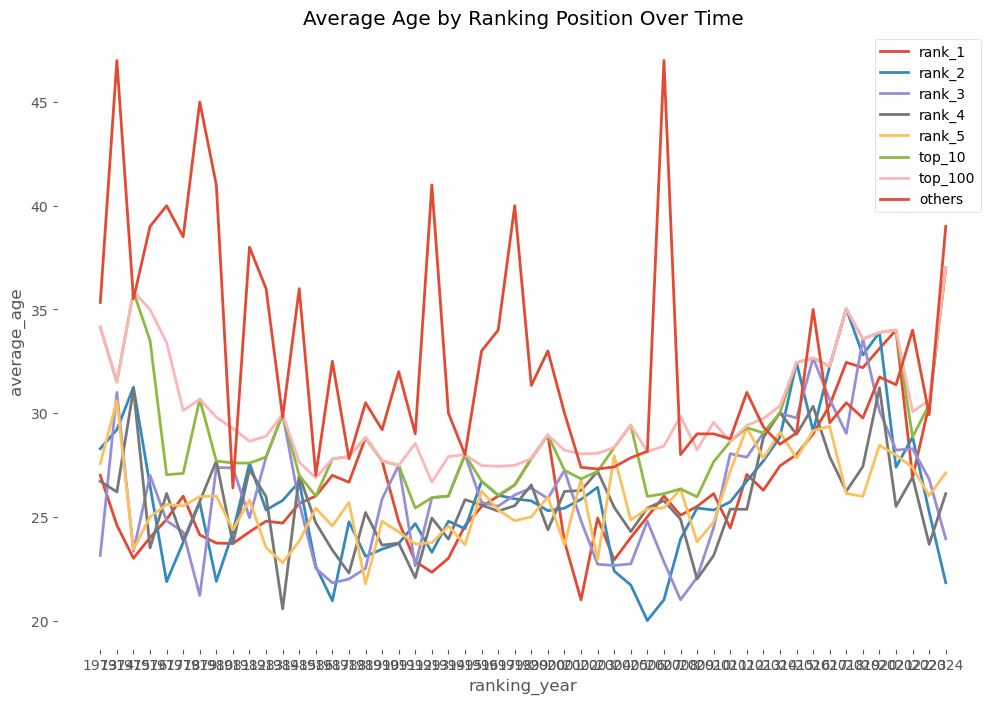

In [196]:
# visualise the dataset

df = pd.read_sql_query ("SELECT * FROM top_rank",conn)
df = df.sort_values ("ranking_year") 

#convert wide into long 
df_long = df.melt(
    id_vars="ranking_year",
    value_vars=["rank_1", "rank_2", "rank_3", "rank_4", "rank_5", "top_10","top_100","others"],
    var_name="rank",
    value_name="average_age"
)
plt.figure()

        
for rank in df_long["rank"].unique():
    subset = df_long[df_long["rank"] == rank]
    plt.plot(
        subset["ranking_year"],
        subset["average_age"],
        label=rank,
        linewidth=2
    )

plt.xlabel("ranking_year")
plt.ylabel("average_age")
plt.title("Average Age by Ranking Position Over Time")
plt.legend()
plt.show()


In [197]:
cursor = conn.cursor()

cursor.execute("""
CREATE TEMP TABLE RankedPlayers AS
WITH RankedPlayers AS (
    SELECT
        ranking_year,
        player_name,
        ranking_year - CAST(SUBSTR(dob, 1, 4) AS INT) AS age,
        ROW_NUMBER() OVER(PARTITION BY ranking_year, player_name ORDER BY ranking_year ASC) AS rn
    FROM
        zxc
    WHERE rank = 1
)

SELECT
    ranking_year,
    player_name,
    age
FROM
    RankedPlayers
WHERE rn = 1
ORDER BY age ASC
LIMIT 10;
""")


In [198]:
# Query the existing table 
cursor = conn.cursor ()
cursor.execute("SELECT * FROM RankedPlayers")

# Use pandas to display the results
df = pd.read_sql_query("SELECT * FROM RankedPlayers", conn)
print(df)

  ranking_year     player_name  age
0         2022  Carlos Alcaraz   19
1         2000     Marat Safin   20
2         2001  Lleyton Hewitt   20
3         2023  Carlos Alcaraz   20
4         1977      Bjorn Borg   21
5         1980    John McEnroe   21
6         2001     Marat Safin   21
7         2002  Lleyton Hewitt   21
8         2003    Andy Roddick   21
9         1974   Jimmy Connors   22


In [199]:
cursor = conn.cursor()

cursor.execute("""
CREATE TEMP TABLE handplay AS
select hand, count(*) as cases, avg(rank) as ranking_by_hand
from zxc
group by hand
limit 10;
""")


In [200]:
cursor = conn.cursor ()
cursor.execute("SELECT * FROM handplay")
df = pd.read_sql_query("SELECT * FROM handplay", conn)
print(df)

   hand    cases  ranking_by_hand
0  None      132      1564.613636
1     A     2833       657.063537
2     L   280721       674.141439
3     R  2252681       731.679624
4     U   699272      1267.496626


In [206]:
cursor = conn.cursor ()
cursor.execute("""
CREATE TEMP TABLE lefthand AS
SELECT
    rank,
    (sum(CASE WHEN hand = 'L' THEN 1 ELSE 0 END) / CAST(count(*) AS REAL)) * 100 AS lefties_percentage
FROM
    zxc
WHERE rank < 10
GROUP BY
    rank
LIMIT 10;
""")


OperationalError: table lefthand already exists

In [207]:
cursor = conn.cursor ()
cursor.execute("SELECT * FROM lefthand")
df = pd.read_sql_query("SELECT * FROM lefthand", conn)
print(df)

   rank  lefties_percentage
0     1           19.804183
1     2           31.111111
2     3           19.340463
3     4           14.864263
4     5           15.829257
5     6           15.768374
6     7           12.277580
7     8            9.617097
8     9           13.555556


In [236]:
cursor = conn.cursor()

cursor.execute("""
CREATE TEMP TABLE zxcjd AS
SELECT  r.ranking_year
        ,r.points 
        ,r.rank, p.*, p.name_first||" "||p.name_last as player_name
FROM  ranking_enriched as r
LEFT JOIN players as p ON p.player_id = r.player
""")

conn.commit()

In [239]:
cursor = conn.cursor()
cursor.execute("""
CREATE TEMP TABLE countrypoints AS
SELECT ioc, sum(points) as country_points  -- Changed 'points' to 'point' assuming the column is named 'point'
FROM zxcjd
GROUP BY ioc
ORDER BY country_points desc
limit 10;
""")

In [240]:
cursor = conn.cursor ()
cursor.execute("SELECT * FROM countrypoints")
df = pd.read_sql_query("SELECT * FROM countrypoints", conn)
print(df)

   ioc  country_points
0  ESP      36793743.0
1  USA      33538077.0
2  FRA      26570241.0
3  GER      19830850.0
4  ARG      19049895.0
5  ITA      15012498.0
6  RUS      13703189.0
7  AUS      13322279.0
8  SUI      11696039.0
9  SRB      11587096.0


In [242]:
cursor = conn.cursor()
cursor.execute("""
CREATE TEMP TABLE player_country AS
SELECT
    ranking_year,
    MAX(CASE WHEN ioc = 'ESP' THEN highest_ranked_player END) AS ESP,
    MAX(CASE WHEN ioc = 'USA' THEN highest_ranked_player END) AS USA,
    MAX(CASE WHEN ioc = 'FRA' THEN highest_ranked_player END) AS FRA,
    MAX(CASE WHEN ioc = 'ARG' THEN highest_ranked_player END) AS ARG,
    MAX(CASE WHEN ioc = 'ITA' THEN highest_ranked_player END) AS ITA,
    MAX(CASE WHEN ioc = 'RUS' THEN highest_ranked_player END) AS RUS,
    MAX(CASE WHEN ioc = 'SUI' THEN highest_ranked_player END) AS SUI,
    MAX(CASE WHEN ioc = 'SRB' THEN highest_ranked_player END) AS SRB    
FROM (
    SELECT
        ioc,
        ranking_year,
        MIN(rank) AS highest_ranked_player
    FROM
        zxcjd
    WHERE ioc IN ('ESP', 'USA','FRA','GER','ARG','ITA','RUS','AUS','SUI','SRB')
    GROUP BY
        ioc, ranking_year
) subquery
GROUP BY
    ranking_year
ORDER BY
    ranking_year;
""")

In [243]:
cursor = conn.cursor ()
cursor.execute("SELECT * FROM player_country")
df = pd.read_sql_query("SELECT * FROM player_country", conn)
print(df)

   ranking_year  ESP  USA  FRA  ARG  ITA    RUS  SUI     SRB
0          1973    2    3   23   27    8   32.0  126   111.0
1          1974    9    1   20    5   12    9.0  148   121.0
2          1975    5    1   26    2   14   13.0  156    92.0
3          1976    4    1   19    3    6   47.0  190   134.0
4          1977    4    1   27    2    7   60.0  234    68.0
5          1978    7    1   38    2    7  144.0   48   122.0
6          1979    7    1   22    3   10    NaN   51   312.0
7          1980    7    1   12    4   19  249.0   24   309.0
8          1981   23    1   12    4   17    NaN   23     NaN
9          1982    7    1    9    2   39    NaN   36   450.0
10         1983    6    1    4    4   35  616.0   25     NaN
11         1984    7    1    5    8   22  180.0   23     NaN
12         1985   19    1    5   19   21  131.0   26     NaN
13         1986   14    1    3   14   31   30.0   22     NaN
14         1987   14    1    4   13   37   32.0   23     NaN
15         1988   14    

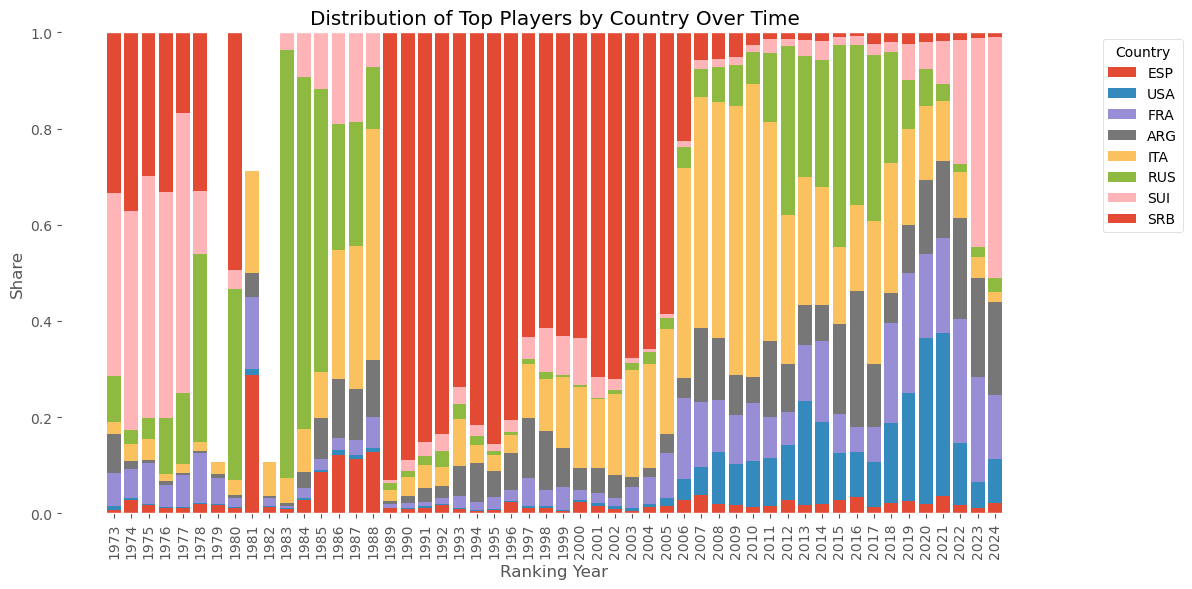

In [248]:
df = pd.read_sql_query("SELECT * FROM player_country", conn)
df = df.sort_values("ranking_year") 
countries = ["ESP", "USA", "FRA", "ARG", "ITA", "RUS", "SUI", "SRB"]

df_prop = df.copy()
df_prop[countries] = df_prop[countries].div(df_prop[countries].sum(axis=1), axis=0)
plt.figure(figsize=(12, 6))  # Wider figure to accommodate all years

bottom = np.zeros(len(df_prop))

for country in countries:
    plt.bar(
        df_prop["ranking_year"],
        df_prop[country],
        bottom=bottom,
        label=country,
        width=0.8
    )
    bottom += df_prop[country].values

plt.xlabel("Ranking Year")
plt.ylabel("Share")
plt.title("Distribution of Top Players by Country Over Time")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc="upper left")

# Ensure all years are displayed on x-axis
all_years = sorted(df_prop["ranking_year"].unique())
plt.xticks(all_years, rotation=90)

# Add grid lines to make it easier to see alignment
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Columns in dataframe: ['ranking_year', 'ESP', 'USA', 'FRA', 'ARG', 'ITA', 'RUS', 'SUI', 'SRB']
SRB data sample: 0    111.0
1    121.0
2     92.0
3    134.0
4     68.0
Name: SRB, dtype: float64


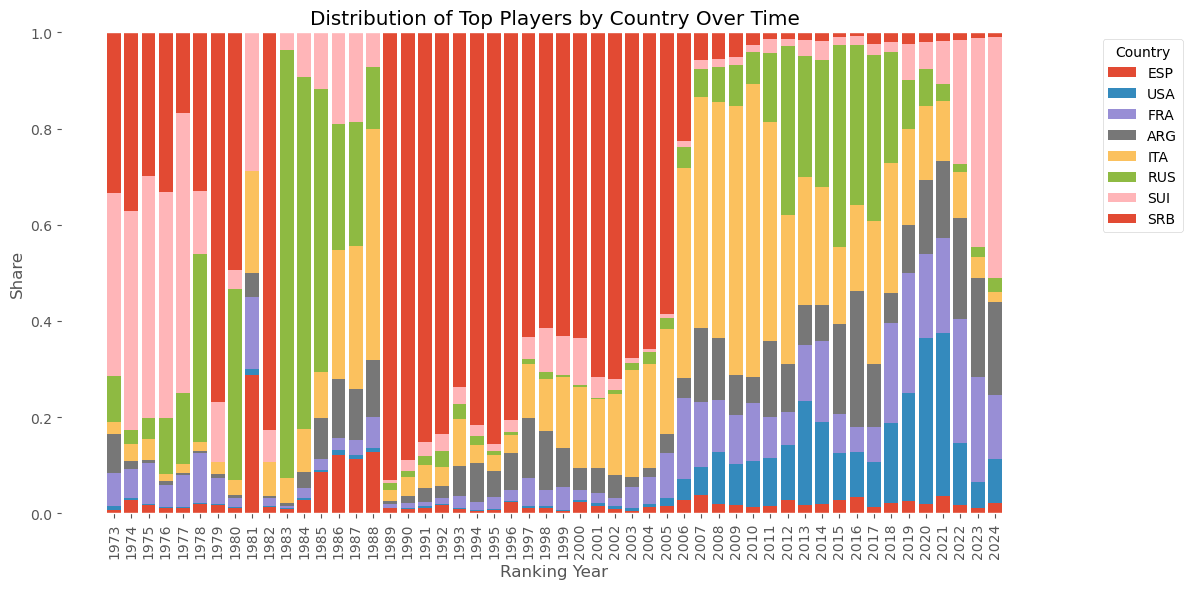

In [250]:
df = pd.read_sql_query("SELECT * FROM player_country", conn)
df = df.sort_values("ranking_year") 
countries = ["ESP", "USA", "FRA", "ARG", "ITA", "RUS", "SUI", "SRB"]

# Check if SRB exists in the dataframe
print("Columns in dataframe:", df.columns.tolist())
print("SRB data sample:", df["SRB"].head() if "SRB" in df.columns else "SRB column not found")

# Fill NaN values with 0 to ensure all countries have values
for country in countries:
    if country in df.columns:
        df[country] = df[country].fillna(0)
    else:
        print(f"Warning: {country} not found in dataframe columns")

df_prop = df.copy()
# Avoid division by zero by adding a small epsilon
df_prop[countries] = df_prop[countries].div(df_prop[countries].sum(axis=1) + 1e-10, axis=0)

plt.figure(figsize=(12, 6))

bottom = np.zeros(len(df_prop))

for country in countries:
    if country in df.columns:
        plt.bar(
            df_prop["ranking_year"],
            df_prop[country],
            bottom=bottom,
            label=country,
            width=0.8
        )
        bottom += df_prop[country].values

plt.xlabel("Ranking Year")
plt.ylabel("Share")
plt.title("Distribution of Top Players by Country Over Time")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc="upper left")

# Ensure all years are displayed on x-axis
all_years = sorted(df_prop["ranking_year"].unique())
plt.xticks(all_years, rotation=90)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

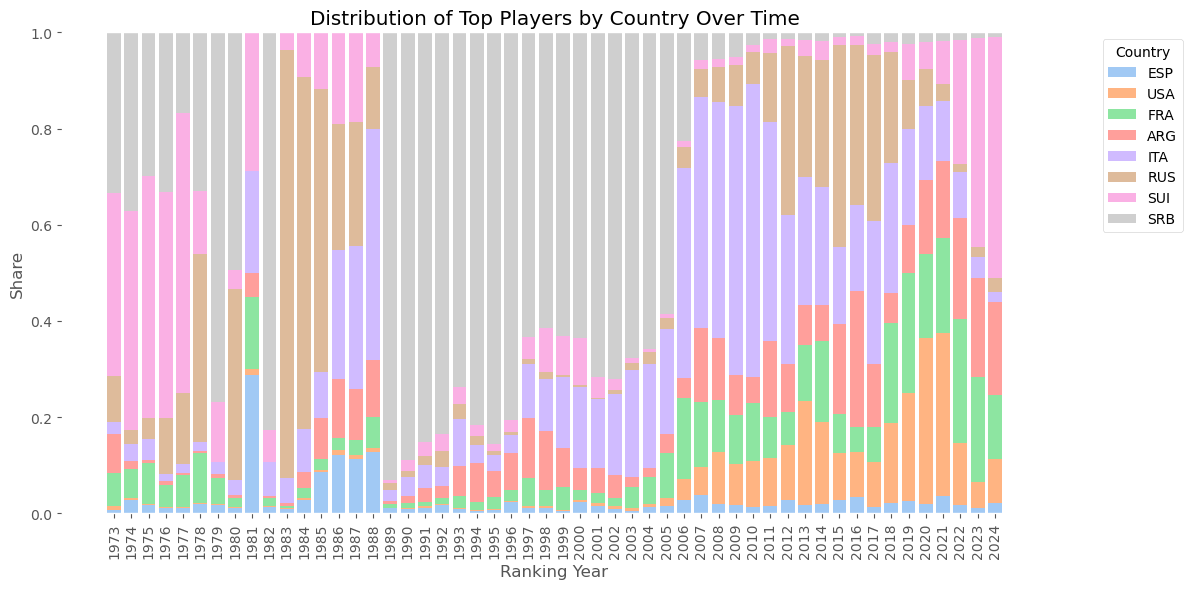

In [251]:
df = pd.read_sql_query("SELECT * FROM player_country", conn)
df = df.sort_values("ranking_year") 
countries = ["ESP", "USA", "FRA", "ARG", "ITA", "RUS", "SUI", "SRB"]

# Fill NaN values with 0 to ensure all countries have values
for country in countries:
    if country in df.columns:
        df[country] = df[country].fillna(0)

df_prop = df.copy()
df_prop[countries] = df_prop[countries].div(df_prop[countries].sum(axis=1) + 1e-10, axis=0)

plt.figure(figsize=(12, 6))

# Create a pastel color palette
pastel_colors = sns.color_palette("pastel", len(countries))

bottom = np.zeros(len(df_prop))

for i, country in enumerate(countries):
    if country in df.columns:
        plt.bar(
            df_prop["ranking_year"],
            df_prop[country],
            bottom=bottom,
            label=country,
            width=0.8,
            color=pastel_colors[i]  # Use pastel colors
        )
        bottom += df_prop[country].values

plt.xlabel("Ranking Year")
plt.ylabel("Share")
plt.title("Distribution of Top Players by Country Over Time")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc="upper left")

# Ensure all years are displayed on x-axis
all_years = sorted(df_prop["ranking_year"].unique())
plt.xticks(all_years, rotation=90)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()